<a href="https://colab.research.google.com/github/anunezcr/Proyecto_ML/blob/master/Proyecto_05Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso: Aprendizaje Automático - Proyecto final (preliminar al 4 Sept)
## Alonso Nuñez / Sergio Castillo
## Fecha de entrega: 9 setiembre 2019

## Importar dependencias y cargar el dataset
## Para pruebas cargar dataset de una sucursal (10 años) , o de todas las sucursales (1 año)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

data =  pd.read_csv('https://raw.githubusercontent.com/anunezcr/datasets/master/clientes_diarios_clasif_unaSucursal.csv')
#data =  pd.read_csv('https://raw.githubusercontent.com/anunezcr/datasets/master/clientes_diarios_clasif_todasSucursales.csv')

Using TensorFlow backend.


# EDA
## Revisar el tamaño del data set y ver algunas instancias:

In [0]:
print("Dimensiones:", data.shape)
data.head(5)

Dimensiones: (22631, 14)


,id_tienda,tipo_tienda,provincia,supervisor,mes_del_anio,semana_del_anio,es_quincena,es_feriado,dia_de_la_semana,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,volumen
0,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,VERDADERO,Anio Nuevo,Jueves,17.0,6.0,385.0,167.0,bajo
1,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,VERDADERO,NO,Viernes,19.0,7.0,400.0,147.0,bajo
2,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,VERDADERO,NO,Sabado,20.0,6.0,409.0,166.0,medio
3,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,FALSO,NO,Domingo,19.0,6.0,455.0,185.0,medio
4,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,FALSO,NO,Lunes,19.0,7.0,301.0,83.0,bajo


## Validaciones de valores en columnas

In [0]:
print("Valores distintos de la columna es quincena:")
print(data.es_quincena.unique())
print("\nValores distintos de la columna es feriado:")
print(data.es_feriado.unique())
print("\nValores distintos de la columna dia de la semana:")
print(data.dia_de_la_semana.unique())
print("\nValores distintos de la columna volumen:")
print(data.volumen.unique())

Valores distintos de la columna es quincena:
[' VERDADERO ' ' FALSO ' nan]

Valores distintos de la columna es feriado:
[' Anio Nuevo ' ' NO ' ' Jueves Santo ' ' Viernes Santo ' ' Sabado Santo '
 ' Dia del Trabajo ' ' Anexion del Partido de Nicoya a Costa Rica '
 ' Dia de la Virgen de los angeles ' ' Dia de la Madre '
 ' Dia de la Independencia ' ' Dia de las Culturas ' ' Dia de Navidad '
 ' Fiesta de Fin de Anio ' ' Dia de Juan Santamaria '
 ' Dia de las Culturas - Dia Feriado ' nan]

Valores distintos de la columna dia de la semana:
['Jueves' 'Viernes' 'Sabado' 'Domingo' 'Lunes' 'Martes' 'Miercoles' nan]

Valores distintos de la columna volumen:
['bajo' 'medio' 'alto' nan]


## Visualización de datos

Distribución de los valores en columna horas operacion:


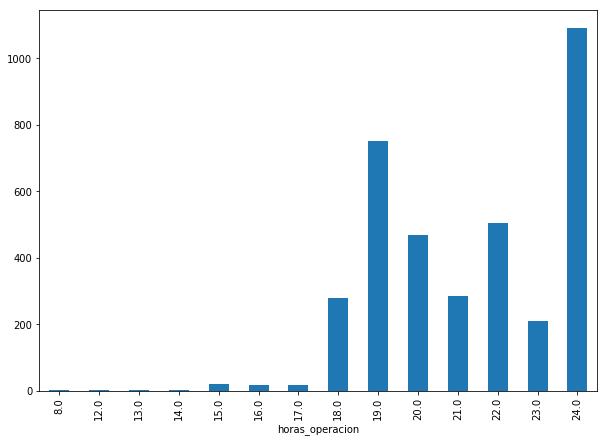

In [0]:
print("Distribución de los valores en columna horas operacion:")
data.groupby('horas_operacion')['horas_operacion'].count().plot(kind = "bar", figsize = (10, 7))

Distribución de los valores en columna pos en uso:


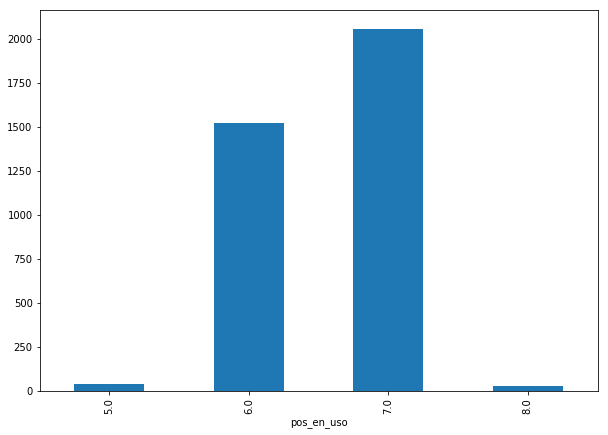

In [0]:
print("Distribución de los valores en columna pos en uso:")
data.groupby('pos_en_uso')['pos_en_uso'].count().plot(kind = "bar", figsize = (10, 7))

# Pre-Procesado

## Convertir features de texto en numéricos (pero aún categóricos)

In [0]:
df = data.copy()  #Creamos una copia para mantener el DF original intacto
df['dia_de_la_semana'] = data['dia_de_la_semana'].replace(
    {'Lunes' : 0, 'Martes' : 1, 'Miercoles' : 2, 'Jueves' : 3, 'Viernes' : 4, 'Sabado' : 5, 'Domingo' : 6}
)
df['volumen'] = data['volumen'].replace({'alto' : 0, 'medio' : 1, 'bajo' : 2})
df['es_quincena'] = data['es_quincena'].replace({' VERDADERO ' : 1, ' FALSO ' : 0})

In [0]:
#Este caso especial primero cambiamos la palabra NO por un 0 y luego cambiamos cualquier otro valor por un 1
df['es_feriado'] = data['es_feriado'].replace({' NO ': 0})
df['es_feriado'] = df['es_feriado'].where(df['es_feriado'] == 0, other = 1)
df['es_feriado'].head(5)
print("Verificar resultado final:")
df.head(100)

Verificar resultado final:


,id_tienda,tipo_tienda,provincia,supervisor,mes_del_anio,semana_del_anio,es_quincena,es_feriado,dia_de_la_semana,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,volumen
0,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,1.0,1,3.0,17.0,6.0,385.0,167.0,2.0
1,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,1.0,0,4.0,19.0,7.0,400.0,147.0,2.0
2,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,1.0,0,5.0,20.0,6.0,409.0,166.0,1.0
3,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,0.0,0,6.0,19.0,6.0,455.0,185.0,1.0
4,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,0.0,0,0.0,19.0,7.0,301.0,83.0,2.0
5,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,0.0,0,1.0,18.0,7.0,307.0,94.0,2.0
6,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,0.0,0,2.0,19.0,7.0,305.0,95.0,2.0
7,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,0.0,0,3.0,19.0,7.0,288.0,75.0,2.0
8,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,0.0,0,4.0,20.0,6.0,372.0,98.0,2.0
9,xyz,FS,SAN JOSE,2015622_080,1.0,2.0,0.0,0,5.0,19.0,6.0,446.0,189.0,1.0


## Eliminar outliers

Las variables que nos interesan son las de cantidad de clientes, comparamos clientes totales vs. VIP para cada día y decidimos borrar aquellos valores que exceden la norma, que dentro del conjunto de datos no iban a aportar mayor detalle.

Tamaño original: (22631, 14)
Tamaño después de borrado: (3637, 14)


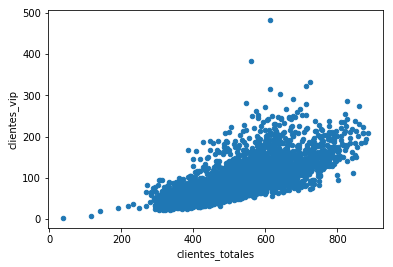

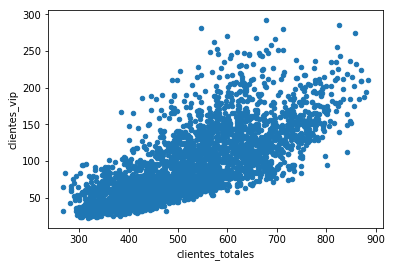

In [0]:
df.plot.scatter(x = 'clientes_totales', y = 'clientes_vip')
print("Tamaño original:", df.shape)

# para data set de todas las sucursales:
#df1 = df[df.clientes_vip < 100]
#df1 = df1[df1.clientes_totales < 800]

# para data set de una sucursal:
df1 = df[df.clientes_vip < 300]
df1 = df1[df1.clientes_totales > 250]

print("Tamaño después de borrado:", df1.shape)
df1.plot.scatter(x = 'clientes_totales', y = 'clientes_vip')

## Convertir datos categóricos - One-hot encoding

In [0]:
# One-hot encoding
df2 = pd.get_dummies(df1, columns=['mes_del_anio', 'dia_de_la_semana', 'volumen'])
df2.head()



,id_tienda,tipo_tienda,provincia,supervisor,semana_del_anio,es_quincena,es_feriado,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,mes_del_anio_1.0,mes_del_anio_2.0,mes_del_anio_3.0,mes_del_anio_4.0,mes_del_anio_5.0,mes_del_anio_6.0,mes_del_anio_7.0,mes_del_anio_8.0,mes_del_anio_9.0,mes_del_anio_10.0,mes_del_anio_11.0,mes_del_anio_12.0,dia_de_la_semana_0.0,dia_de_la_semana_1.0,dia_de_la_semana_2.0,dia_de_la_semana_3.0,dia_de_la_semana_4.0,dia_de_la_semana_5.0,dia_de_la_semana_6.0,volumen_0.0,volumen_1.0,volumen_2.0
0,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,1,17.0,6.0,385.0,167.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,0,19.0,7.0,400.0,147.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,0,20.0,6.0,409.0,166.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,19.0,6.0,455.0,185.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,19.0,7.0,301.0,83.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


## Normalizar features horas_operacion y pos_en_uso

In [0]:
# Normalizando horas_operacion y pos_en_uso para el intervalo 0 a 1
df2["horas_operacion"] = df2["horas_operacion"]/24
df2["pos_en_uso"] = df2["pos_en_uso"]/8
df2.head(10)

,id_tienda,tipo_tienda,provincia,supervisor,semana_del_anio,es_quincena,es_feriado,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,mes_del_anio_1.0,mes_del_anio_2.0,mes_del_anio_3.0,mes_del_anio_4.0,mes_del_anio_5.0,mes_del_anio_6.0,mes_del_anio_7.0,mes_del_anio_8.0,mes_del_anio_9.0,mes_del_anio_10.0,mes_del_anio_11.0,mes_del_anio_12.0,dia_de_la_semana_0.0,dia_de_la_semana_1.0,dia_de_la_semana_2.0,dia_de_la_semana_3.0,dia_de_la_semana_4.0,dia_de_la_semana_5.0,dia_de_la_semana_6.0,volumen_0.0,volumen_1.0,volumen_2.0
0,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,1,0.708333,0.750,385.0,167.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,0,0.791667,0.875,400.0,147.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,xyz,FS,SAN JOSE,2015622_080,1.0,1.0,0,0.833333,0.750,409.0,166.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,0.791667,0.750,455.0,185.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,0.791667,0.875,301.0,83.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,0.750000,0.875,307.0,94.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
6,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,0.791667,0.875,305.0,95.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
7,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,0.791667,0.875,288.0,75.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
8,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,0.833333,0.750,372.0,98.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9,xyz,FS,SAN JOSE,2015622_080,2.0,0.0,0,0.791667,0.750,446.0,189.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


## Borrar NaNs

In [0]:
print ("Shape antes: ", df2.shape)
print ("Hay Nans? ", df2.isnull().values.any())   #preguntar si hay NaN
# remove NaNs
df2 = df2.dropna()
print ("Shape después: ", df2.shape)

Shape antes:  (3637, 33)
Hay Nans?  False
Shape después:  (3637, 33)


## Elección de columnas (features)

Para este corte se elimina todas las columnas que brindan info específica de tiendas pues solamente se analizará una tienda.

La columna semana del año y mes del año no brindan mayor información en conjunto, es posible que sean redundantes por lo que probaremos removiendo una de ellas.

In [0]:
cols_to_drop = ['id_tienda', 'tipo_tienda', 'provincia', 'supervisor', 'semana_del_anio', 'clientes_totales', 'clientes_vip']

processed = df2.drop(cols_to_drop, 1)
features_qty = processed.shape[1] - 3 # 3: cantidad de clases
print("Tamaño post-procesamiento:", processed.shape)
processed.head(5)

Tamaño post-procesamiento: (3637, 26)


,es_quincena,es_feriado,horas_operacion,pos_en_uso,mes_del_anio_1.0,mes_del_anio_2.0,mes_del_anio_3.0,mes_del_anio_4.0,mes_del_anio_5.0,mes_del_anio_6.0,mes_del_anio_7.0,mes_del_anio_8.0,mes_del_anio_9.0,mes_del_anio_10.0,mes_del_anio_11.0,mes_del_anio_12.0,dia_de_la_semana_0.0,dia_de_la_semana_1.0,dia_de_la_semana_2.0,dia_de_la_semana_3.0,dia_de_la_semana_4.0,dia_de_la_semana_5.0,dia_de_la_semana_6.0,volumen_0.0,volumen_1.0,volumen_2.0
0,1.0,1,0.708333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,1.0,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,1.0,0,0.833333,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0.0,0,0.791667,0.750,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0.0,0,0.791667,0.875,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


# Inicia el trabajo con los modelos elegidos, que serán:
   **DecisionTree**

   **RandomForest**
   
   **Redes Neuronales ANN**

In [0]:
# Splitting the data input into X, and the labels y 
X = np.array(processed)[:,0:features_qty]
X = X.astype('float32')
y = keras.utils.to_categorical(df1["volumen"],3)

Determinar cuáles columnas son features y cuáles labels.

En este caso las clases están dadas por "volumen" que indica si es un día alto volumen (cantidad de clientes), medio o bajo

In [0]:

# Splitting the data input into X, and the labels y 
features = np.array(processed)[:,0:features_qty]
features = features.astype('float32')
labels = keras.utils.to_categorical(df1["volumen"],3)

print("Shape of features:", features.shape)
print("\nShape of labels:", labels.shape)
print("\nFirst 5 rows of features")
print(features[:5])
print("\nFirst 5 rows of labels")
print(labels[:5])

features[0]



Shape of features: (3637, 23)

Shape of labels: (3637, 3)

First 5 rows of features
[[1.        1.        0.7083333 0.75      1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        1.        0.
  0.        0.       ]
 [1.        0.        0.7916667 0.875     1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        1.
  0.        0.       ]
 [1.        0.        0.8333333 0.75      1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  1.        0.       ]
 [0.        0.        0.7916667 0.75      1.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        1.       ]
 [0.        0.        0.7916667 0.875     1.

array([1.       , 1.       , 0.7083333, 0.75     , 1.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 1.       , 0.       , 0.       , 0.       ],
      dtype=float32)

Separa set de entrenamiento y set de pruebas
Con una proporción 75% - 25%

In [0]:
X_train,X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state = 13) 

print ("shape del dataset completo: ", processed.shape)
print ("\nshape del set de entrenamiento: ", X_train.shape)
print ("\nshape del set de pruebas: ", y_test.shape)

shape del dataset completo:  (3637, 26)

shape del set de entrenamiento:  (2727, 23)

shape del set de pruebas:  (910, 3)


## Modelo clasificador usando DecisionTree

In [0]:
DecisionTreeModel = DecisionTreeClassifier(max_depth=3,min_samples_leaf=1)

#entrenamiento
print(DecisionTreeModel.fit(X_train, y_train))

#prediccion (usar datos de test)
y_predict = DecisionTreeModel.predict(X_test)

print("\nAccuracy para DecisionTree: {:.4f}".format(accuracy_score(y_test, y_predict)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Accuracy para DecisionTree: 0.7231


## Modelo clasificador usando RandomForest

In [0]:
RandomForestModel = RandomForestClassifier(min_samples_leaf=5, min_samples_split=15, n_estimators=280, max_depth = 20, random_state = 10)

#entrenamiento
print(RandomForestModel.fit(X_train, y_train))

#prediccion (usar datos de test)
y_predict = RandomForestModel.predict(X_test)

print("\nAccuracy para Random Forest:     {:.4f}".format(accuracy_score(y_test, y_predict)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=280,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

Accuracy para Random Forest:     0.7286


## Modelo clasificador usando ANN

In [0]:


# Building the model


model = Sequential()

#capas intermedias
model.add(Dense(256, input_dim=features_qty))
model.add(Activation('relu'))
model.add(Dropout(.2)) # now using dropout


#model.add(Dense(128))
#model.add(Activation('tanh'))
#model.add(Dropout(.2)) # now using dropout

model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dropout(.1)) # now using dropout

#capa de salida
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.summary()

# Training the model

epochs = 2000
batch_size = 100

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               6144      
_________________________________________________________________
activation_85 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 32)                8224      
_________________________________________________________________
activation_86 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 3)               